# Sigmoid 量化

对于定义域 $\mathbb{R}$ 中的输入，sigmoid 函数将输入变换为区间 $(0, 1)$ 上的输出。因此，sigmoid 通常称为挤压函数（squashing function）：它将范围 $(- \infty, \infty)$ 中的任意输入压缩到区间 $(0, 1)$ 中的某个值，sigmoid 函数定义如下：

$$
\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}
$$

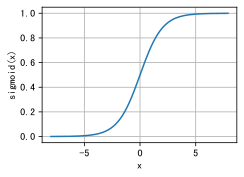

In [1]:
import numpy as np
import torch
from torch_book import plotx

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
plotx.plot(x.detach(), y.detach(), 
           'x', 'sigmoid(x)')

sigmoid 函数特性：

$$
\operatorname{sigmoid}(x) + \operatorname{sigmoid}(-x) = 1
$$

sigmoid 函数的导数为下面的公式：

$$
\frac{\operatorname{d}}{\operatorname{d} x} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right) = \operatorname{sigmoid}(x)\operatorname{sigmoid}(-x)
$$

可视化导函数：

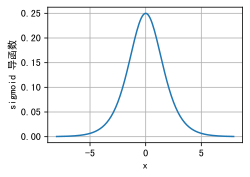

In [2]:
y.backward(torch.ones_like(x), retain_graph=True)
plotx.plot(x.detach(), x.grad, 
           'x', 'sigmoid 导函数')

$$
\operatorname{g}(t) = \int_{-\infty}^t \frac{\operatorname{d}}{\operatorname{d} x} \operatorname{sigmoid}(x) \operatorname{d} x
$$

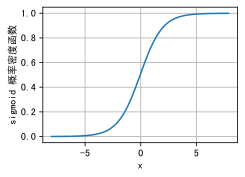

In [3]:
x.grad.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
p = x.grad.cumsum(dim=0) * 0.1
plotx.plot(x.detach(), p, 
           'x', 'sigmoid 概率密度函数')

sigmoid 函数于 $x_0$ 处的泰勒展示式：

$$
\operatorname{sigmoid}(x) = \operatorname{sigmoid}(x_0)( 1 + \operatorname{sigmoid}(-x_0) \sum_{k=1}^{\infty} \cfrac{(x - x_0)^k}{k!})
$$

## 区间分划

由于 sigmoid 函数关于 $y = 0.5$ 对称，故仅仅考虑 $x > 0$ 的部分即可。

由 sigmoid 及其导函数图像可以看出：$x \in [-6, 6]$ 的函数值以及导数值变化剧烈。依此可以将此范围外的函数值直接设定为极限值即可。

```{note}
对于 $n$ **分划**：

$$
\Delta: a=x_0 < x_1 < \cdots < x_n =b 
$$

在每个子段 $[x_i, x_{i+1}]$ 构造插值多项式，并将其拼接起来，即 **分段插值**。

若函数 $S_k(x)$ 在分划 $\delta$ 的每个子段 $[x_i, x_{i+1}]$ 都是 $k$ 次多项式，则称 $S_k(x)$ 为具有分划 $\delta$ 的 **分段 $k$ 次式**。点 $x_i$ （$i=0,1,\cdots,n$）称作 $S_k(x)$ 的节点。
```

为了提高量化精度，在 $[0, 6]$ 上考虑分段插值。取 $n=10$，依据 sigmoid 导函数的变化趋势可设定 $S_k(x)$ 的节点为：

In [4]:
nodes = 0, 0.25, 0.5, 0.75, 1, 2, 2.5, 3, 4, 5, 6
len(nodes)

11

In [5]:
x = torch.tensor(nodes, requires_grad=True)
y = torch.sigmoid(x)
y

tensor([0.5000, 0.5622, 0.6225, 0.6792, 0.7311, 0.8808, 0.9241, 0.9526, 0.9820,
        0.9933, 0.9975], grad_fn=<SigmoidBackward0>)

In [6]:
y.backward(torch.ones_like(x), retain_graph=True)
x.grad

tensor([0.2500, 0.2461, 0.2350, 0.2179, 0.1966, 0.1050, 0.0701, 0.0452, 0.0177,
        0.0066, 0.0025])

## uint8 量化

先看看简单的方案：

In [7]:
def Qz(v, s):
    k = s * v - np.floor(v * s)
    o = k > 0.5
    return o.astype("int")

def Q(v, s):
    x = np.floor(v * s) + Qz(v, s)
    return x/s

In [8]:
scale = (1 << 8) - 1
with torch.no_grad():
    qy = Q(y.numpy(), scale)
    qy = torch.from_numpy(qy)

In [9]:
from torch.ao.quantization.observer import MinMaxObserver, MovingAverageMinMaxObserver, HistogramObserver


dtype = torch.quint8
qscheme = torch.per_tensor_affine

config = {
    "dtype": dtype,
    "qscheme": qscheme
}
observers = [MinMaxObserver(**config),
             MovingAverageMinMaxObserver(**config),
             HistogramObserver(**config)]

In [10]:
for obs in observers:
    obs(y)
    s, z = obs.calculate_qparams()
    print(obs.__class__.__name__, s, z)

MinMaxObserver tensor([0.0039]) tensor([0], dtype=torch.int32)
MovingAverageMinMaxObserver tensor([0.0039]) tensor([0], dtype=torch.int32)
HistogramObserver tensor([0.0039]) tensor([0], dtype=torch.int32)


In [11]:
with torch.no_grad():
    _y = (torch.floor(y/s) + z) * s
_y

tensor([0.4967, 0.5593, 0.6218, 0.6766, 0.7274, 0.8800, 0.9230, 0.9504, 0.9816,
        0.9895, 0.9973])

In [12]:
qy

tensor([0.4980, 0.5608, 0.6235, 0.6784, 0.7294, 0.8824, 0.9255, 0.9529, 0.9804,
        0.9922, 0.9961], dtype=torch.float64)

In [13]:
y

tensor([0.5000, 0.5622, 0.6225, 0.6792, 0.7311, 0.8808, 0.9241, 0.9526, 0.9820,
        0.9933, 0.9975], grad_fn=<SigmoidBackward0>)

## Sigmoid 观测器

In [14]:
from sympy import interpolating_spline, symbols, exp, simplify, oo

def sigmoid(x):
    x = 1 + exp(-x)
    return 1/x

x = symbols("x")
# simplify(sigmoid(1) + sigmoid(-1))
node_indexes = [-6, -5, -3, -2, -1, 0, 1, 2, 3, 5, 6]
sigmoid_sym = interpolating_spline(1,
                                   x,
                                   node_indexes,
                                   [float(sigmoid(n)) for n in node_indexes])

In [15]:
sigmoid_sym

Piecewise((0.00422022776765008*x + 0.0277939897625353, (x >= -6) & (x <= -5)), (0.020366511126641*x + 0.10852540655749, (x >= -5) & (x <= -3)), (0.0717770488445508*x + 0.262757019711219, (x >= -3) & (x <= -2)), (0.149738499347878*x + 0.418679920717873, (x >= -2) & (x <= -1)), (0.231058578630005*x + 0.5, ((x >= -1) | (x >= 0)) & ((x >= -1) | (x <= 1)) & ((x >= 0) | (x <= 0)) & ((x <= 0) | (x <= 1))), (0.149738499347878*x + 0.581320079282127, (x >= 1) & (x <= 2)), (0.0717770488445508*x + 0.737242980288781, (x >= 2) & (x <= 3)), (0.020366511126641*x + 0.891474593442511, (x >= 3) & (x <= 5)), (0.00422022776765008*x + 0.972206010237465, (x >= 5) & (x <= 6)))

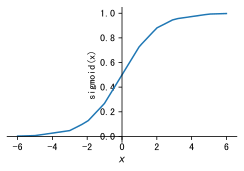

In [16]:
from sympy.plotting import plot

plot(sigmoid_sym, ylabel="sigmoid(x)")